In [23]:
from scripts.geometry_corrector import GeometryCorrector
from scripts.shrink_volume import VolumeShrinker
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionData, AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Normaliser, Binner, Slicer
from cil.plugins.astra.operators import ProjectionOperator
from cil.io import TIFFWriter
from cil.utilities.display import show2D, show_geometry
from cil.plugins.astra.processors import FBP

import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os


In [2]:
file_path = '/mnt/share/ALC_laminography/folder/k11-67208_binned.nxs'
cor = 0 # pix
tilt = 35 # deg

optimise_geometry = True
cor_bounds = (-20, 20) # pixels
tilt_bounds = (30, 40) # deg
tilt_tol = 0.01 # deg
cor_tol = 0.01 # pixels

TEM grid sample with some movement, grid search for robustness

In [3]:
image_key = HDF5_utilities.read(filename=file_path, dset_path='entry/instrument/imaging/image_key')

unique_keys, counts = np.unique(image_key, return_counts=True)
for key, count in zip(unique_keys, counts):
    key_type = {0: "Tomography", 1: "Flat field", 2: "Dark field"}.get(key, f"Unknown ({key})")
    print(f"  {key_type} images: {count}")

data = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 0,))
flat = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 1,))
dark = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 2,))

angles = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging_sum/smaract_zrot_value_set')
pixel_size_x = HDF5_utilities.read(filename=file_path, dset_path='/entry/tomo_entry/instrument/detector/x_pixel_size')
pixel_size_y = HDF5_utilities.read(filename=file_path, dset_path='/entry/tomo_entry/instrument/detector/y_pixel_size')


  Tomography images: 4000
  Flat field images: 50
  Dark field images: 50


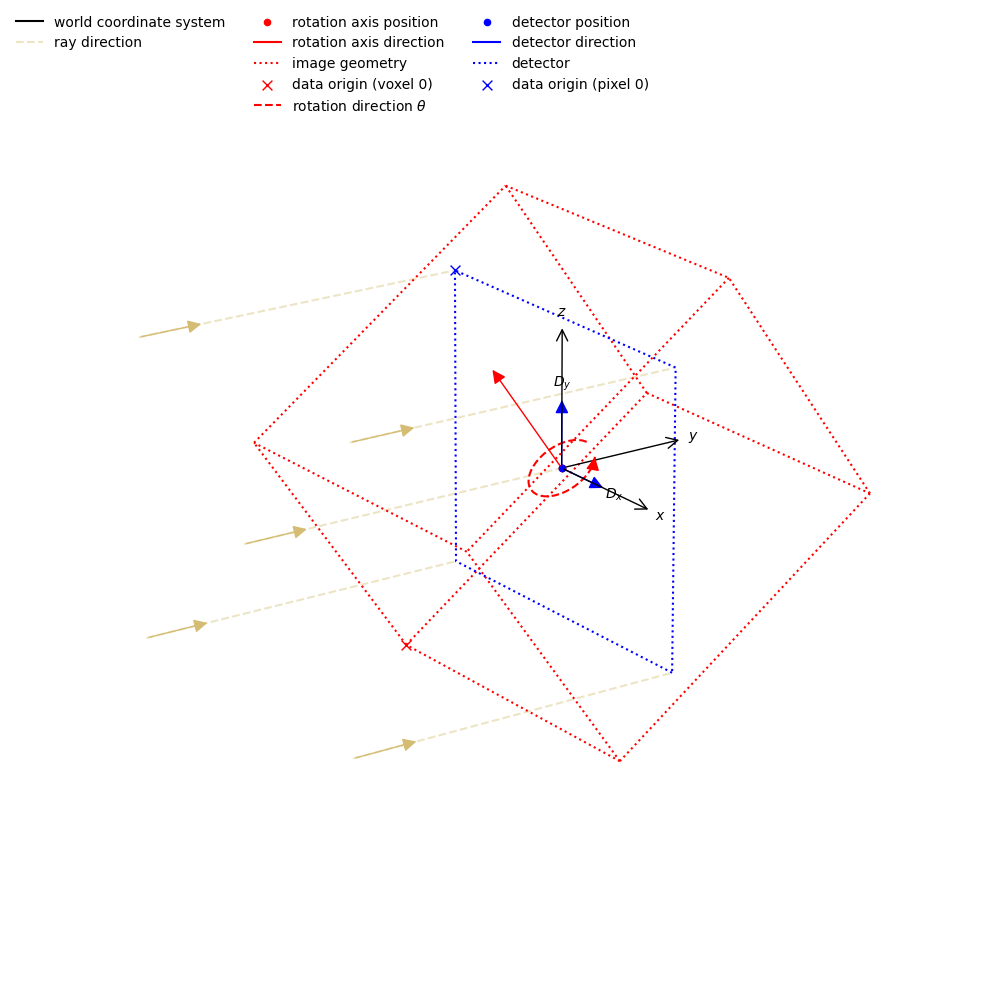

In [4]:
tilt_direction_vector=np.array([1, 0, 0])
original_rotation_axis=np.array([0, 0, 1])

rotation_matrix = R.from_rotvec(np.deg2rad(tilt) * tilt_direction_vector)
tilted_rotation_axis = rotation_matrix.apply(original_rotation_axis)

ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_direction=tilted_rotation_axis)
ag.set_angles(angles[image_key==0,])
ag.set_panel([data.shape[2], data.shape[1]],
             pixel_size = (pixel_size_x, pixel_size_y),
             origin='top-left')

ag.set_centre_of_rotation(offset=cor, distance_units='pixels')


ag.config.system.rotation_axis.direction = tilted_rotation_axis

show_geometry(ag)

data = AcquisitionData(data, geometry=ag)

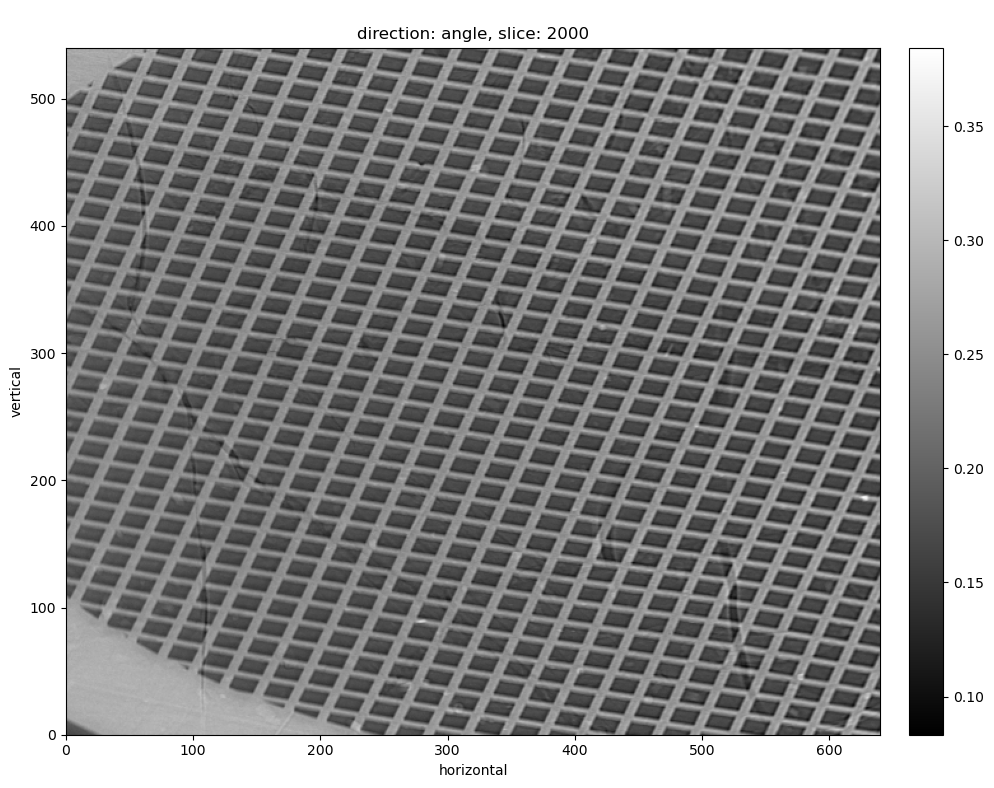

In [5]:
data = Normaliser(np.mean(flat, axis=0), np.mean(dark, axis=0))(data)
data = TransmissionAbsorptionConverter(min_intensity=1e-6)(data)
show2D(data)

In [6]:
data.reorder('astra')
print(data.dimension_labels)

(<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)


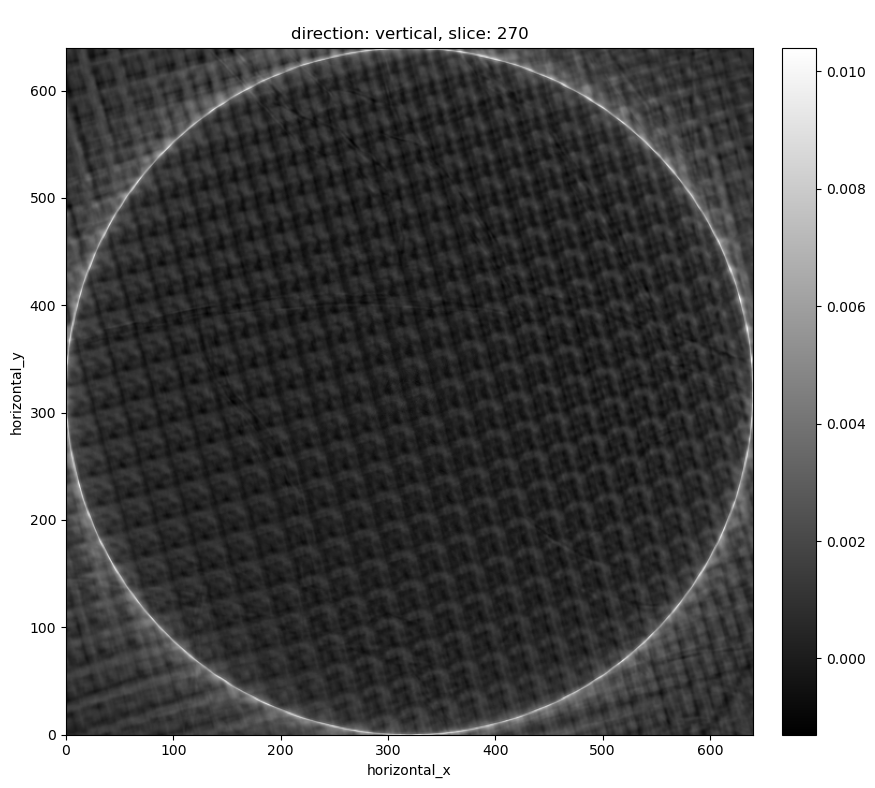

In [7]:
ag = data.geometry
ig = ag.get_ImageGeometry()

fbp = FBP(ig, ag)
recon = fbp(data)
show2D(recon)

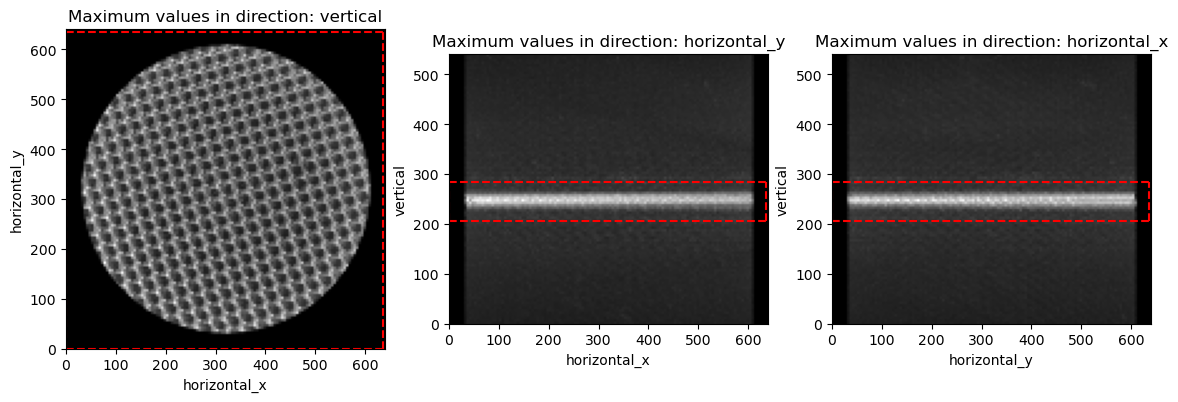

In [8]:
if optimise_geometry:
    vs = VolumeShrinker()
    ig = vs.run(data, auto=True, buffer=5)

`GeometryCorrector` starts with a coarse minimisation using an initial_binning in detector space, then does a fine minimisation at full resolution. The search bounds and tolerance are set at the top of the notebook

Tilt bounds : (30.000:40.000), CoR bounds : (-20.000:20.000)
tilt: 35.000, CoR: 0.000, loss: 3.871e+05
tilt: 33.820, CoR: 0.000, loss: 3.837e+05
tilt: 36.180, CoR: 0.000, loss: 3.863e+05
tilt: 32.361, CoR: 0.000, loss: 3.826e+05
tilt: 31.459, CoR: 0.000, loss: 3.854e+05
tilt: 32.858, CoR: 0.000, loss: 3.817e+05
tilt: 32.946, CoR: 0.000, loss: 3.817e+05
tilt: 33.013, CoR: 0.000, loss: 3.817e+05
tilt: 32.985, CoR: 0.000, loss: 3.817e+05
tilt: 32.982, CoR: 0.000, loss: 3.817e+05
tilt: 32.989, CoR: 0.000, loss: 3.817e+05
tilt: 32.998, CoR: 0.000, loss: 3.817e+05
tilt: 32.992, CoR: 0.000, loss: 3.817e+05
tilt: 32.989, CoR: -4.721, loss: 3.866e+05
tilt: 32.989, CoR: 4.721, loss: 3.681e+05
tilt: 32.989, CoR: 10.557, loss: 3.699e+05
tilt: 32.989, CoR: 6.595, loss: 3.743e+05
tilt: 32.989, CoR: 1.115, loss: 3.782e+05
tilt: 32.989, CoR: 3.344, loss: 3.683e+05
tilt: 32.989, CoR: 5.065, loss: 3.690e+05
tilt: 32.989, CoR: 4.073, loss: 3.674e+05
tilt: 32.989, CoR: 4.063, loss: 3.674e+05
tilt: 32.989,

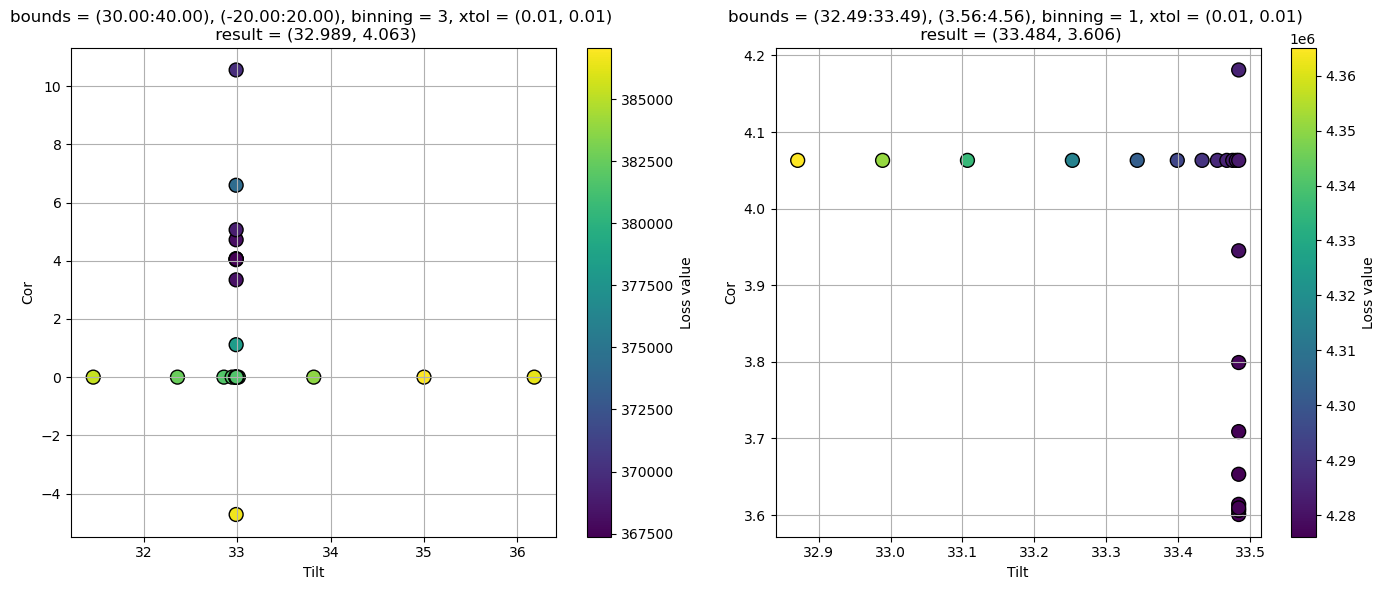

In [9]:
if optimise_geometry:

    if data.get_dimension_size('horizontal') > 1280:
        final_binning = 2
    else:
        final_binning = None
    
    processor = GeometryCorrector(initial_parameters=(tilt, cor), parameter_bounds=(tilt_bounds, cor_bounds), parameter_tolerance=(tilt_tol, cor_tol),
                                  final_binning=final_binning, reduced_volume=ig)

    processor.set_input(data)
    data_corrected = processor.get_output()

    processor.plot_evaluations()

Finally we do a full resolution reconstruction using the minimised parameters and look at some vertical slices throughout the volume

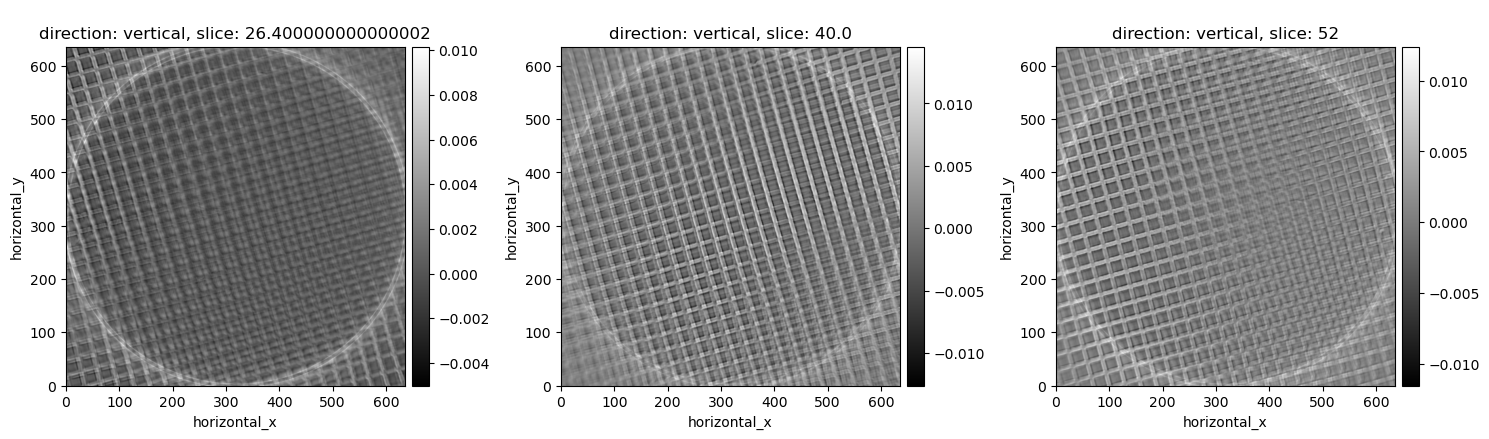

In [ ]:
if optimise_geometry:
    recon = FBP(ig, data_corrected.geometry)(data_corrected)
    slice_list = [('vertical',  int(ig.voxel_num_z)*0.33), ('vertical', int(ig.voxel_num_z)*0.5), ('vertical', int(ig.voxel_num_z*0.66))]
    show2D(recon, slice_list=slice_list, num_cols=3)

The reconstruction doesn't look perfect, especially for slices away from the central one. We should check if there is some movement in the sample during acquisition.

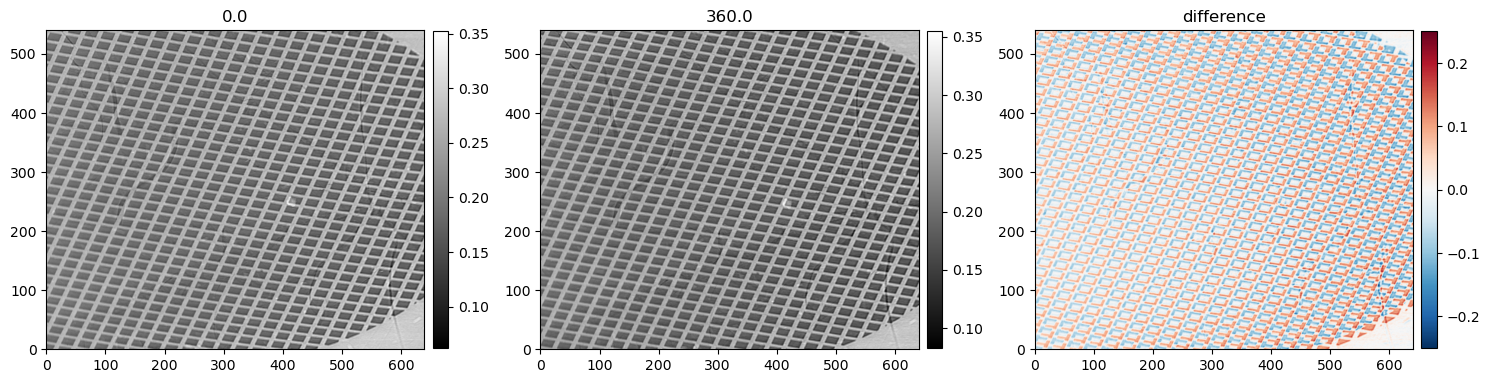

In [12]:
show2D([data.array[:,0,:], data.array[:,-1,:], data.array[:,0,:]-data.array[:,-1,:]],
       [data.geometry.angles[0], data.geometry.angles[-1], "difference"],
       fix_range=[None, None, (-0.25, 0.25)],
       cmap=["gray","gray","RdBu_r"],
       num_cols=3)

As there is movement, we try instead a brute force grid search

In [13]:
binning  = 3
data_binned = Binner(roi={'horizontal':(None, None,binning), 'vertical':(None, None,binning), 'angle':(None, None, 4)})(data)
ag_binned = data_binned.geometry
ig_binned = Binner(roi={'horizontal_x':(None, None,binning), 'horizontal_y':(None, None,binning), 'vertical':(None, None,binning)})(ig)

In [14]:
cors = np.arange(0, 20, 1)
tilts = np.arange(30, 40, 1)

ag_binned = data_binned.geometry

target = max(np.ceil(data_binned.get_dimension_size('angle') / 10), 36)
divider = np.floor(data_binned.get_dimension_size('angle') / target)
y_ref = Slicer(roi={'angle':(None, None, divider)})(data_binned)
ag_ref = Slicer(roi={'angle':(None, None, divider)})(ag_binned)

losses = np.empty([len(tilts),len(cors)])

processor = GeometryCorrector(initial_parameters=(tilt, cor))

for t, tilt_deg in enumerate(tilts):
    for c, cor in enumerate(cors):

        cor_pix = cor /binning
        tilt_rad = np.deg2rad(tilt_deg)
        rotation_matrix = R.from_rotvec(tilt_rad * tilt_direction_vector)
        tilted_rotation_axis = rotation_matrix.apply(original_rotation_axis)

        ag_binned.set_centre_of_rotation(offset=cor_pix, distance_units='pixels')
        ag_binned.config.system.rotation_axis.direction = tilted_rotation_axis

        recon = FBP(ig_binned, ag_binned)(data_binned)

        ag_ref = processor.update_geometry(ag_ref, tilt_deg, cor_pix)
        A = ProjectionOperator(ig_binned, ag_ref)
        
        yhat = A.direct(recon)
        r = yhat - y_ref
        
        losses[t, c] = processor.loss_from_residual(r)

        print(f"{t * len(cors) + c + 1} of {len(tilts)*len(cors)}" )


1 of 200
2 of 200
3 of 200
4 of 200
5 of 200
6 of 200
7 of 200
8 of 200
9 of 200
10 of 200
11 of 200
12 of 200
13 of 200
14 of 200
15 of 200
16 of 200
17 of 200
18 of 200
19 of 200
20 of 200
21 of 200
22 of 200
23 of 200
24 of 200
25 of 200
26 of 200
27 of 200
28 of 200
29 of 200
30 of 200
31 of 200
32 of 200
33 of 200
34 of 200
35 of 200
36 of 200
37 of 200
38 of 200
39 of 200
40 of 200
41 of 200
42 of 200
43 of 200
44 of 200
45 of 200
46 of 200
47 of 200
48 of 200
49 of 200
50 of 200
51 of 200
52 of 200
53 of 200
54 of 200
55 of 200
56 of 200
57 of 200
58 of 200
59 of 200
60 of 200
61 of 200
62 of 200
63 of 200
64 of 200
65 of 200
66 of 200
67 of 200
68 of 200
69 of 200
70 of 200
71 of 200
72 of 200
73 of 200
74 of 200
75 of 200
76 of 200
77 of 200
78 of 200
79 of 200
80 of 200
81 of 200
82 of 200
83 of 200
84 of 200
85 of 200
86 of 200
87 of 200
88 of 200
89 of 200
90 of 200
91 of 200
92 of 200
93 of 200
94 of 200
95 of 200
96 of 200
97 of 200
98 of 200
99 of 200
100 of 200
101 of 2

Plotting the parameter space we notice it has a strange shape, likely caused by the sample movement.

Text(0, 0.5, 'Tilt (degrees)')

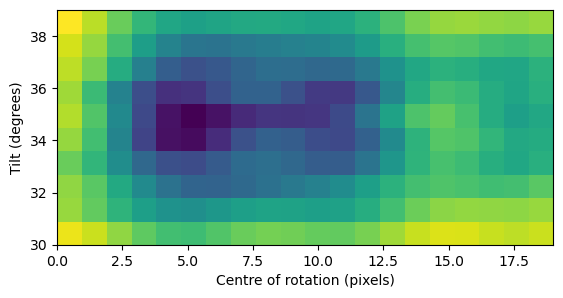

In [15]:
plt.imshow(losses, extent=(cors[0], cors[-1], tilts[0], tilts[-1]), aspect=1, origin='lower')
plt.xlabel('Centre of rotation (pixels)')
plt.ylabel('Tilt (degrees)')

We select a minimum from the plot.

In [16]:
t_idx, c_idx = np.unravel_index(np.argmin(losses), losses.shape)

best_tilt = tilts[t_idx]
best_cor = cors[c_idx]

print(f"Minimum tilt = {best_tilt}, cor = {best_cor}")

Minimum tilt = 35, cor = 5


Try reconstructing this at full resolution

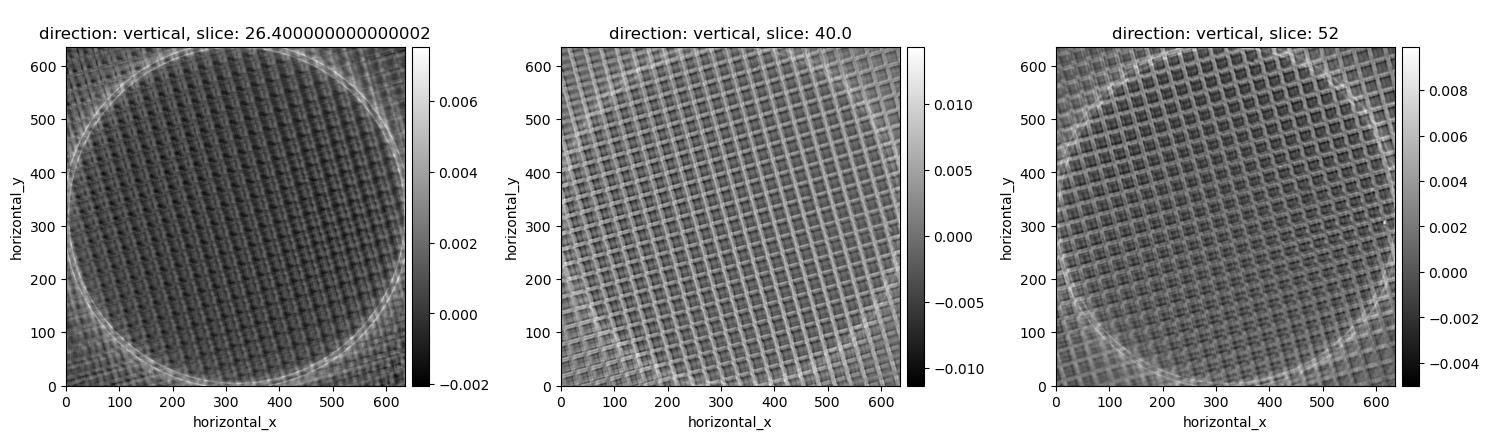

In [ ]:
ag = processor.update_geometry(ag, best_tilt, best_cor)

recon = FBP(ig, ag)(data)
show2D(recon, slice_list=slice_list, num_cols=3)